<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Permanent-spending-increase" data-toc-modified-id="Permanent-spending-increase-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Permanent spending increase</a></span></li></ul></div>

In [2]:
%env NUMBA_DISABLE_JIT=1
import sys
sys.path = ['C:\\Users\\Jesse\\Python Projects\\gEconpy'] + sys.path

import gEconpy as ge
import gEconpy.plotting as gp
import numpy as np

env: NUMBA_DISABLE_JIT=1


In [3]:
mod = ge.gEconModel('rbc_trend_growth.gcn')

Model Building Complete.
Found:
	11 equations
	11 variables
	2 stochastic shocks
		 0 / 2 has a defined prior. 
	6 parameters
		 0 / 6 has a defined prior. 
	4 calibrating equations
	4 parameters to calibrate
 Model appears well defined and ready to proceed to solving.



In [4]:
mod.steady_state()
mod.solve_model(not_loglin_variable=['TR'])

Steady state found! Sum of squared residuals is 1.3011141451520082e-21
Solution found, sum of squared residuals:  1.0630709318015683e-31
Norm of deterministic part: 0.000000000
Norm of stochastic part:    0.000000000


In [5]:
mod.print_steady_state()

C_ss             0.554
G_B_ss           0.200
I_ss             0.246
K_ss             2.889
N_ss             0.333
TR_ss            0.020
Y_ss             1.000
r_G_ss           1.065
r_ss             0.115
tau_ss           0.220
w_ss             2.000


In addition, the following parameter values were calibrated:
A_bar            1.461
beta             0.995
theta_K          0.333
theta_L          1.876


## Permanent spending increase

We can do a dynamic IRF with rho_shock_GB = 1, so that the spending increase never fades away.

In [6]:
mod.free_param_dict

{'G_B_bar': 0.2,
 'delta': 0.025,
 'gamma_X': 1.06,
 'rho_GB': 0.75,
 'rho_tau': 0.75,
 'tau_bar': 0.22}

In [15]:
mod.free_param_dict['rho_GB'] = 1

mod.steady_state()
mod.solve_model(solver='gensys')

Steady state found! Sum of squared residuals is 1.3011141451520082e-21
Gensys found a unique solution.
Policy matrices have been stored in attributes model.P, model.Q, model.R, and model.S
Norm of deterministic part: 0.000000000
Norm of stochastic part:    0.000000000


In [30]:
mod.T.round(3).loc[:, (mod.T.sum(axis=0).abs() > 1e-8)]

,G_B,K,tau
C,-0.199,0.525,-0.019
G_B,1.000,-0.000,0.000
I,0.282,-0.454,-0.585
K,0.023,0.883,-0.047
N,0.239,-0.230,-0.231
TR,-0.165,0.040,0.131
Y,0.159,0.180,-0.154
r,0.159,-0.820,-0.154
r_G,0.012,-0.061,-0.020
tau,0.000,-0.000,0.750


In [8]:
mod.R.round(3)

,epsilon_GB,epsilon_tau
C,-0.994,-0.025
G_B,5.000,0.000
I,1.409,-0.780
K,0.113,-0.063
N,1.193,-0.308
TR,-0.825,0.175
Y,0.795,-0.206
r,0.795,-0.206
r_G,0.059,-0.027
tau,0.000,1.000


In [11]:
# Y_ss = 1, so a 1 CU increase is just 0.01
irf = mod.impulse_response_function(simulation_length=22, shock_size=0.01)
irf = irf.loc[:, 1:].xs(axis=1, level=1, key='epsilon_GB').T

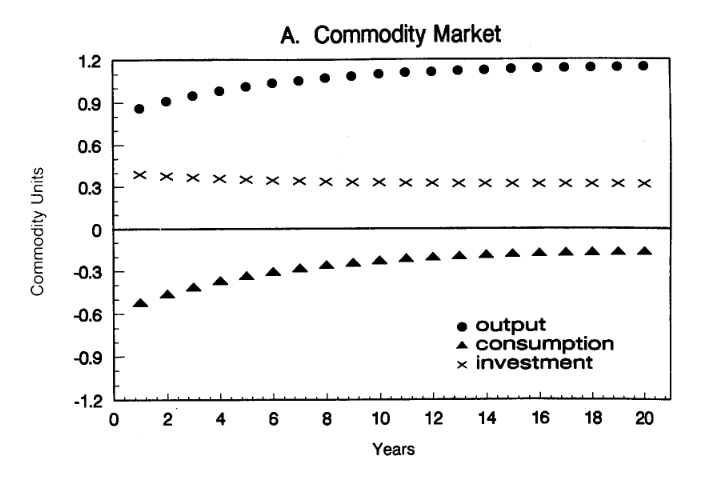


Relative to the real Figure 2, biggest problem is the investment curve. Other dynamics are correct (though the levels are totally off). Error in the model?

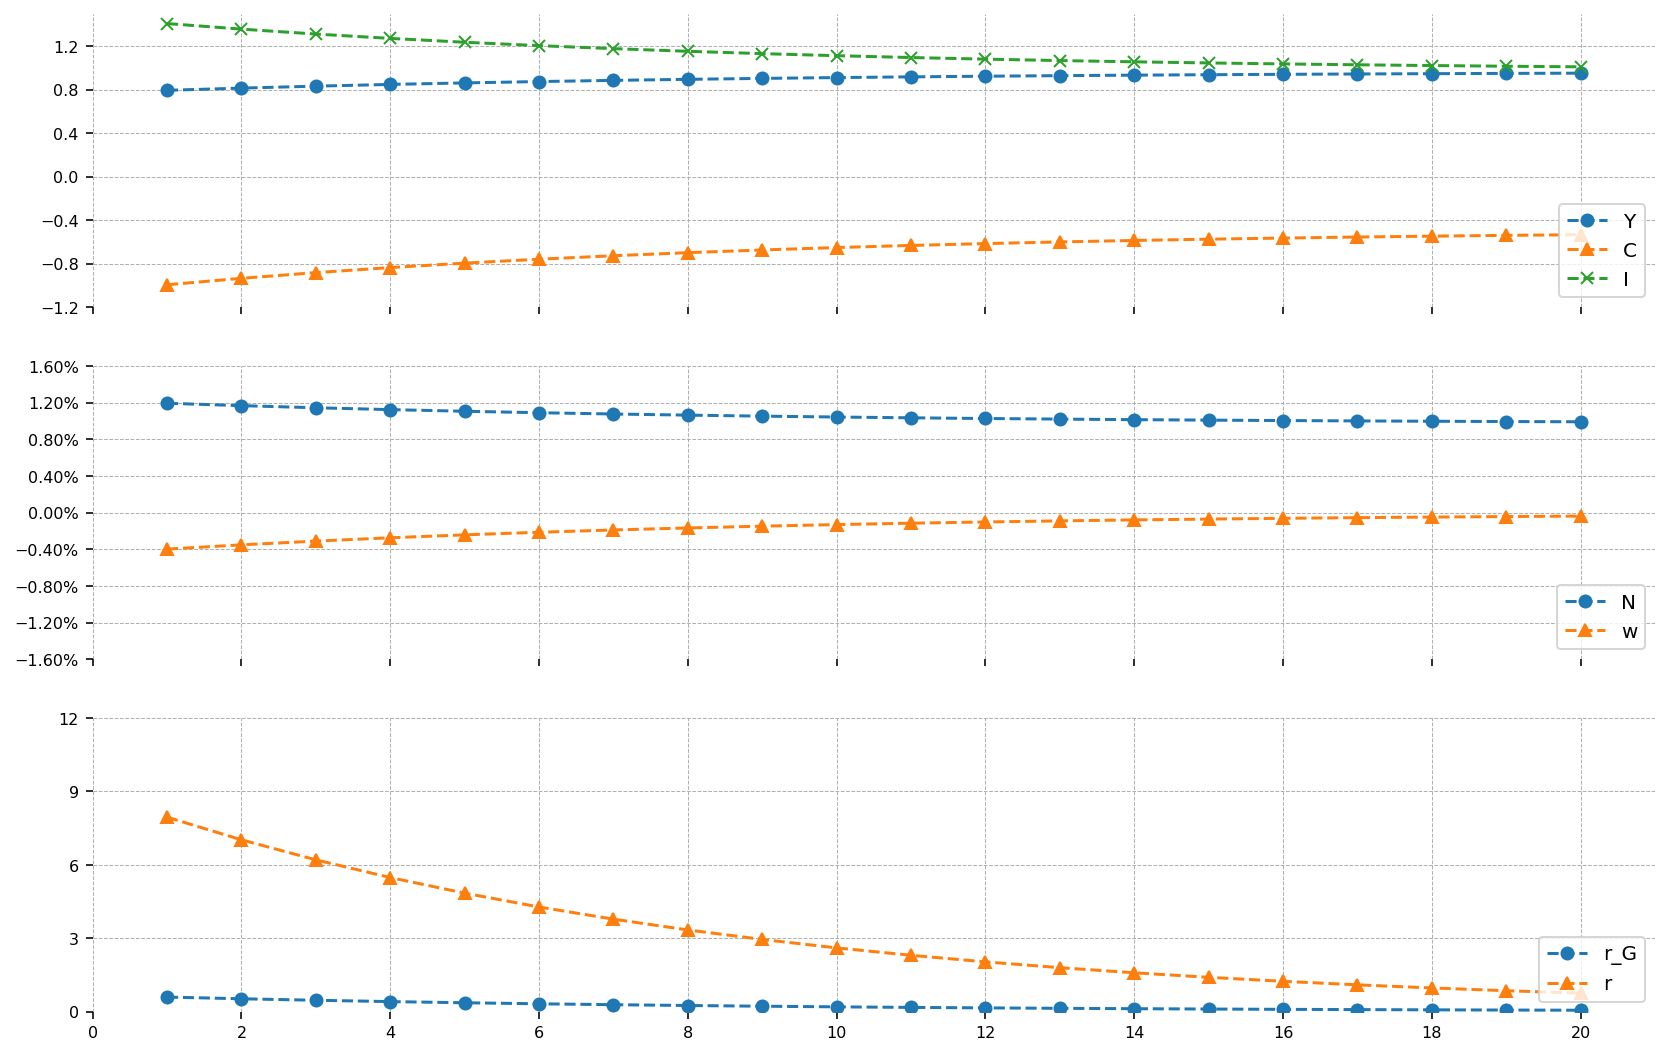

In [13]:
import matplotlib.pyplot as plt
from matplotlib import ticker as mtick
to_plot = [['Y', 'C', 'I'], ['N', 'w'], ['r_G', 'r']]
ylims = [[-1.2, 1.5], [-0.016, 0.016], [0, 12]]
locators = [mtick.MultipleLocator(base=0.4), mtick.MultipleLocator(base=0.004), mtick.MultipleLocator(base=3)]
formatters = [None, mtick.PercentFormatter(1), None]
factors = [100, 1, 1_000]

fig, ax = plt.subplots(3, 1, figsize=(14,9), dpi=144, sharex=True)

for i, (axis, var_list) in enumerate(zip(fig.axes, to_plot)):
    for var, marker in zip(var_list, ['o', '^', 'x']):
        axis.plot(irf.index[:-1], irf.loc[:20, var].mul(factors[i]).values, ls='--', marker=marker, label=var)
#     irf[var_list].mul(factors[i]).plot(ax=axis, marker=['o', '^', 'x'])
    [spine.set_visible(False) for spine in axis.spines.values()]
    axis.grid(ls='--', lw=0.5)
    axis.set_ylim(ylims[i])
    axis.set_xlim([0, 21])
    axis.yaxis.set_major_locator(locators[i])
    axis.xaxis.set_major_locator(mtick.MultipleLocator(2))
    if formatters[i]:
        axis.yaxis.set_major_formatter(formatters[i])
    axis.tick_params(labelsize=8)
    axis.legend(loc='lower right')